# 2. Exploratory data analysis (EDA)

In this notebook we will perform an exploratory data analysis (EDA) to grasp the underlying relationship among attributes after doing some feature transformation by regrouping categories. The present notebook contains the following sections: 

1. Importing packages and dataset
3. Feature transformation
2. Exploration of variable correlations.

## 2.1. Importing packages and dataset

In [1]:
# Import the required packages

import os
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Import pre-processed dataset and load it into a dataframe

# Create path variable
file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/interim/clean.csv'

# Load csv in dataframe
df = pd.read_csv(file, index_col=0)

In [3]:
# Check # of columns and rows imported
df.shape

(79120, 38)

In [4]:
# Print info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79120 entries, 0 to 79329
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79120 non-null  int64  
 1   LeadTime                     79120 non-null  float64
 2   ArrivalDateYear              79120 non-null  int64  
 3   ArrivalDateMonth             79120 non-null  object 
 4   ArrivalDateWeekNumber        79120 non-null  int64  
 5   ArrivalDateDayOfMonth        79120 non-null  int64  
 6   StaysInWeekendNights         79120 non-null  int64  
 7   StaysInWeekNights            79120 non-null  int64  
 8   Adults                       79120 non-null  float64
 9   Children                     79120 non-null  float64
 10  Babies                       79120 non-null  float64
 11  Meal                         79120 non-null  object 
 12  Country                      79120 non-null  object 
 13  MarketSegment   

---
## 2.2. Feature transformation

In this section, we will carry out a series of category regrouping in some features. The objective is to reduce the cardinality of the attributes, so when they will be transformed into numerical variables we do not end up with a high sparse dataset.

Most of the variables are categorical so we cannot use a Pearson's correlation matrix to explore their relationsship. We will use Cramer's V algorithm to assess the association between categorical attributes.

In [5]:
# Checks number of 
df.nunique().sort_values(ascending=False)

ADR                            5389
ReservationDate                 888
ReservationStatusDate           864
CheckOutDate                    800
ArrivalDate                     793
LeadTime                        453
Agent                           224
Company                         204
Country                         166
DaysInWaitingList               114
PreviousBookingsNotCanceled      73
ArrivalDateWeekNumber            53
TotalStay                        34
ArrivalDateDayOfMonth            31
StaysInWeekNights                26
BookingChanges                   18
ReservationMonth                 12
StaysInWeekendNights             12
ArrivalDateMonth                 12
PreviousCancellations            10
AssignedRoomType                  8
MarketSegment                     7
ReservedRoomType                  7
TotalOfSpecialRequests            6
Adults                            5
DistributionChannel               4
Meal                              4
Children                    

In [6]:
# Regroups PreviousCancellations column in fewer categories
df['PreviousCancellations'] = pd.cut(df['PreviousCancellations'], bins=[-np.inf,0,1,np.inf], labels=['0', '1','2+'])

# Regroups PreviousBookingsNotCanceled column in fewer categories
df['PreviousBookingsNotCanceled'] = pd.cut(df['PreviousBookingsNotCanceled'], bins=[-np.inf,0,1,np.inf], labels=['0','1-2','3+'])

# Regroups Country column in fewer categories
cond = (df.Country == 'PRT') | (df.Country == 'FRA') | (df.Country == 'DEU') | (df.Country == 'GRB') | (df.Country == 'ESP') | (df.Country == 'ITA') | (df.Country == 'BEL') | (df.Country == 'BRA') | (df.Country == 'USA') | (df.Country == 'NLD')
df['Country'].where(cond, 'Other', inplace=True)

# Regroup Babies column into binary
df['RequiredCarParkingSpaces'].where(df.RequiredCarParkingSpaces==0, 1, inplace=True)

# Regroup Babies column into binary
df['Babies'].where(df.Babies==0, 1, inplace=True)

# Regroup Children column into binary
df['Children'].where(df.Children==0, 1, inplace=True)

# Regroup Agent column into less categories
df['Agent'] = df['Agent'].map(lambda x: x.strip())
cond = (df.Agent=='9') | (df.Agent=='NULL') | (df.Agent=='1') | (df.Agent=='14') | (df.Agent=='7') | (df.Agent=='6')
df['Agent'].where(cond, 'Other', inplace=True)

# Regroup Company column into less categories
df['Company'] = df['Company'].map(lambda x: x.strip())
df['Company'].where((df.Company=='NULL') | (df.Company=='40'), 'Other', inplace=True)

# Reduces number of categories in TotalOfSpecialRequests column
df['TotalOfSpecialRequests'] = pd.cut(df['TotalOfSpecialRequests'], bins=[-np.inf,0,1,np.inf], labels=['0', '1','2+'])

# Reduces number of categories in TotalOfSpecialRequests column
df['BookingChanges'] = pd.cut(df['BookingChanges'], bins=[-np.inf,0,1,np.inf], labels=['0', '1','2+'])

# Reduces number of categories in TotalOfSpecialRequests column
df['StaysInWeekendNights'] = pd.cut(df['StaysInWeekendNights'], bins=[-np.inf,0,1,2,np.inf], labels=['0','1','2','3+'])

# Reduces number of categories in TotalOfSpecialRequests column
df['StaysInWeekNights'] = pd.cut(df['StaysInWeekNights'], bins=[-np.inf,0,1,2,3,4,5,np.inf], labels=['0','1','2','3','4','5','6+'])

In [7]:
# Converts all non float variables in categorical
df['DaysInWaitingList'] = df['DaysInWaitingList'].astype('float64')
cat_cols = df.select_dtypes(exclude='float64').columns
df[cat_cols] = df[cat_cols].astype('category')

# Convert variables to categorical
df['Adults'] = df['Adults'].astype('category')
df['Children'] = df['Children'].astype('category')
df['Babies'] = df['Babies'].astype('category')

We will create copy of the original df to apply the categorical association analysis, so we can preserve some continuous numerical variables as they are in the original dataset. All variables in the copy dataset 'df_copy' will be transformed into categories. 

In [8]:
# List non relevant variables for the analysis
to_drop = ['ReservationDate', 'ReservationStatusDate', 'CheckOutDate', 
           'ArrivalDate', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 
           'ArrivalDateYear', 'AssignedRoomType']

# Removes features and creates new df for Cramer's V correlation analysis
df_copy = df.drop(to_drop, axis=1)

We will convert numerical variables into categories to apply the categorical association analysis.

In [9]:
# Converts numerical variables into categorical by binning the values in quantiles
df_copy['LeadTime'] = pd.qcut(df['LeadTime'], 10)
df_copy['ADR'] = pd.qcut(df['ADR'], 10)
df_copy['TotalStay'] = pd.cut(df['TotalStay'], bins=[0,1,2,3,4,5,6,7,8,np.inf], labels=['0','1','2','3','4','5','6','7','8+'])
# Converts into binary variable
df_copy['DaysInWaitingList'].where(df_copy.DaysInWaitingList==0, 1, inplace=True)
df_copy['DaysInWaitingList'] = df_copy['DaysInWaitingList'].astype('category')

---
## 2.3. Exploration of variable correlation

In this section, we will explore the relationship across features by examinating the Cramér's V correlation matrix and a pairplot.

Cramér's V (sometimes referred to as Cramér's phi) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946

In [10]:
def cramers_v(x, y):
    '''calculate Cramers V statistic for categorial-categorial association'''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [11]:
def cramers_matrix(data):
    '''Calculates Cramers V statistic matrix for a df. All variables must be categorical'''
    cols = data.columns
    idx = data.columns
    mat = pd.DataFrame()
    for i in cols:
        for j in idx:
            mat.loc[i,j] = cramers_v(data[i], data[j])
    return mat           

In [12]:
# Creates the correlation matrix using Cramer's V on the copy of the dataset
corr_matrix = cramers_matrix(df_copy)

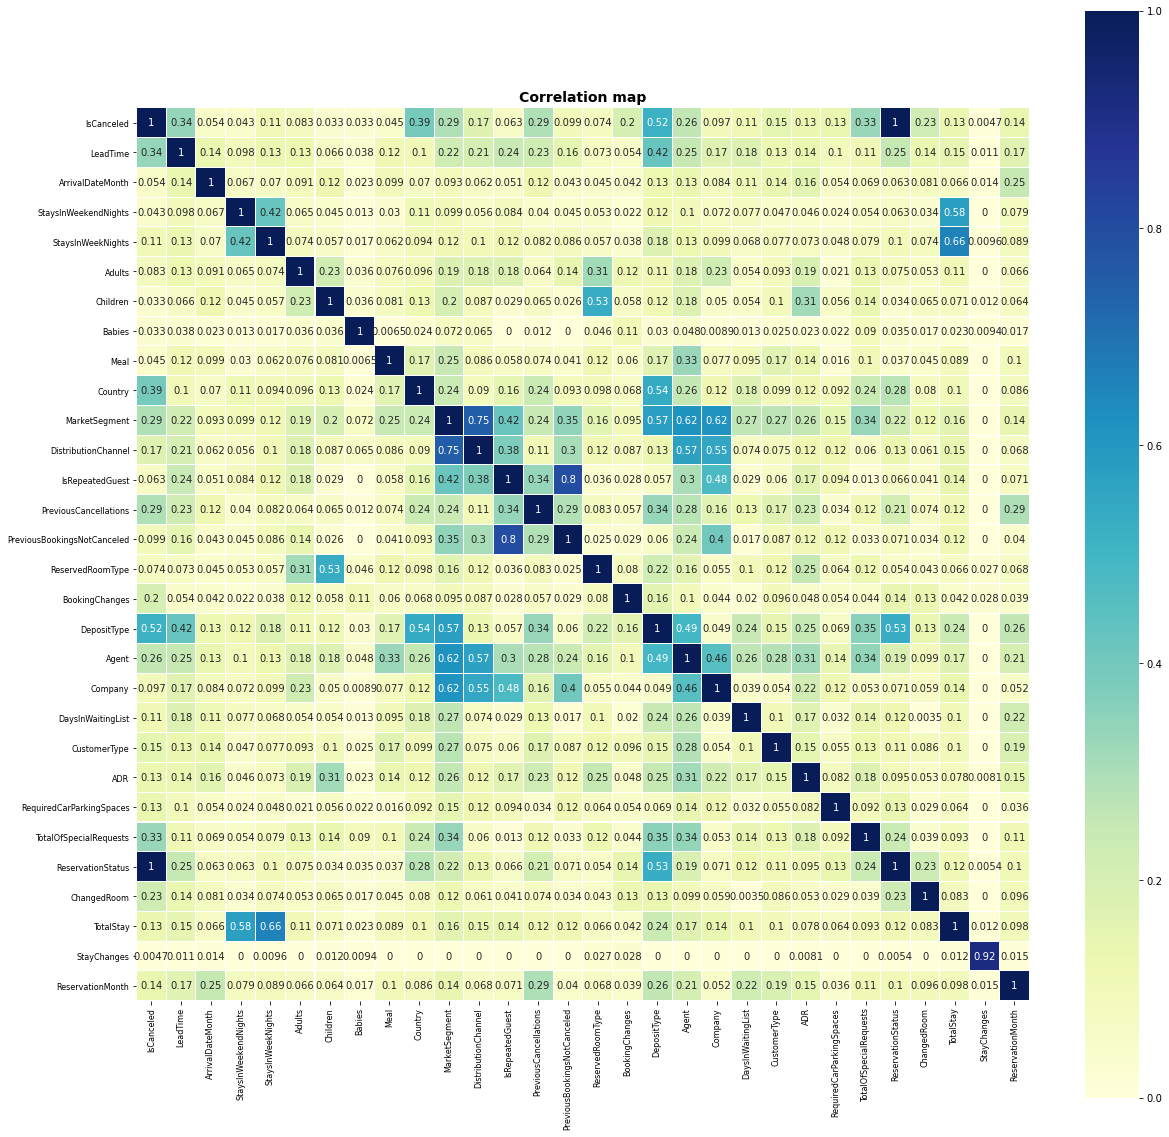

In [13]:
# Plot the correlation matrix with heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, cbar=True, square=True, linewidths=.05, ax=ax)
ax.set_title('Correlation map', weight='bold').set_fontsize('14')
ax.tick_params(labelsize=8)

plt.show()

We can see that there are some variables that are completely correlated and do not add any value: _ReservationStatus_ and _IsCancelled_

In [14]:
# Remove IsCancelled column
df.drop('IsCanceled', axis=1, inplace=True)

In [15]:
# Set visual style for plots
plt.style.use('seaborn')

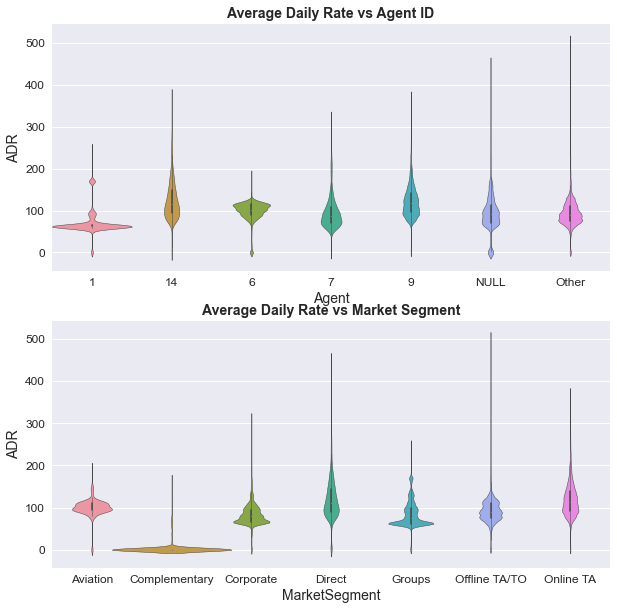

In [16]:
# Creates figure and two axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

# Creates plot on ax1
sns.violinplot(x=df['Agent'], y=df['ADR'], linewidth=0.5, width=1, ax=ax1)
ax1.set_title('Average Daily Rate vs Agent ID', weight='bold').set_fontsize('14')
ax1.tick_params(labelsize=12)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)

# Creates plot on ax2
sns.violinplot(x=df['MarketSegment'], y=df['ADR'], linewidth=0.5, width=1.5, ax=ax2)
ax2.set_title('Average Daily Rate vs Market Segment', weight='bold').set_fontsize('14')
ax2.tick_params(labelsize=12)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

plt.show()

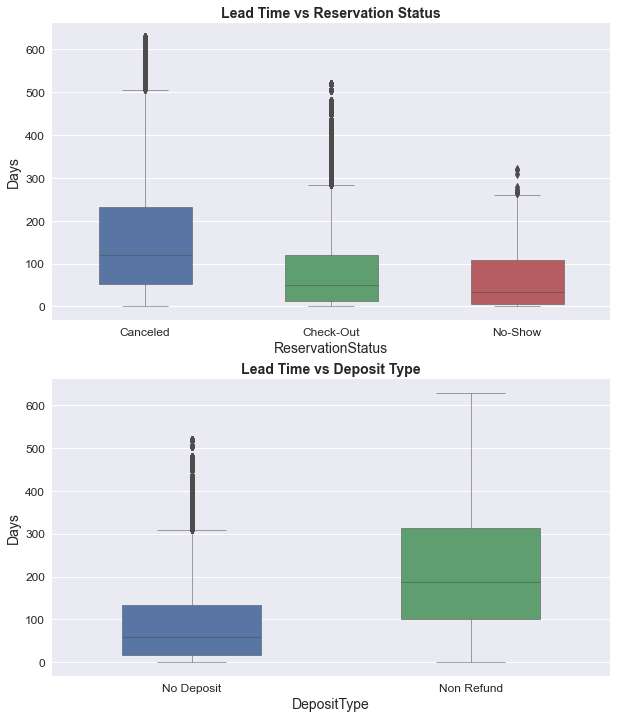

In [17]:
# Creates figure and two axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))

# Creates plot on ax1
sns.boxplot(x=df['ReservationStatus'], y=df['LeadTime'], linewidth=0.5, width=0.5, ax=ax1)
ax1.set_title('Lead Time vs Reservation Status', weight='bold').set_fontsize('14')
ax1.set_ylabel('Days')
ax1.tick_params(labelsize=12)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)

# Creates plot on ax2
sns.boxplot(x=df['DepositType'], y=df['LeadTime'], linewidth=0.5, width=0.5, ax=ax2)
ax2.set_title('Lead Time vs Deposit Type', weight='bold').set_fontsize('14')
ax2.set_ylabel('Days')
ax2.tick_params(labelsize=12)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

plt.show()

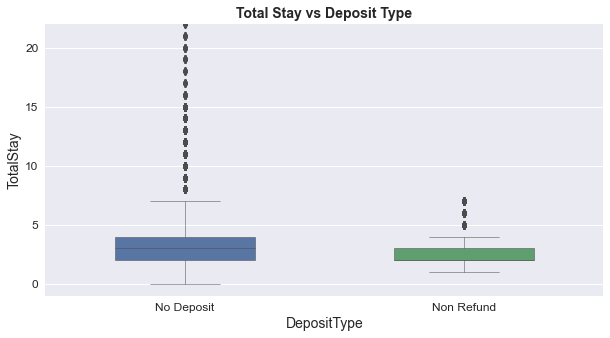

In [18]:
# Creates figure and two axes
fig, ax = plt.subplots(figsize=(10,5))

# Creates plot on ax
sns.boxplot(x=df['DepositType'], y=df['TotalStay'], linewidth=0.5, width=0.5, ax=ax)
ax.set_title('Total Stay vs Deposit Type', weight='bold').set_fontsize('14')
ax.set_ylim(-1,22)
ax.tick_params(labelsize=12)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.show()

---
The resulting dataframe is loaded in a csv file for further steps in a different notebook.

In [19]:
# Writing df dataframe to csv

path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/interim/category_transformation.csv'

df.to_csv(path)